In [1]:
from setup import *
from utils import *

In [2]:
config = {
    # Rendering settings
    'spp': 16, # samples per pixel for rendering
    'threshold': 0.99,
    'bubble_scale': 0.75,
    'use_distorted_jar': True,
    
    # Grid Settings
    'cuboid_grid': {
        'xlength': 10.0, # length in cm along between end point bubbles along x-axis
        'ylength': 10.0,
        'zlength': 0.0,
        'xcount': 11, # number of bubbles in the grid along the x-axis
        'ycount': 11,
        'zcount': 1,
        'origin': [0.0, 0.0, -10.0], # origin of bubble grid
    },
    'cylindrical_grid': {
        'radius': 8.0,
        'height': 0.0,
        'rcount': 8,
        'mtcount': 36,
        'hcount':  1,
        'origin': [0.0, 0.0, -10.0],
    },

    # Circle detection settings
    'hough_params': {
        'method': cv2.HOUGH_GRADIENT_ALT,
        'dp': 1.5,
        'minDist': 10,
        'param1': 150,
        'param2': 0.9,
        'minRadius': 2,
        'maxRadius': 20
    }
}

160


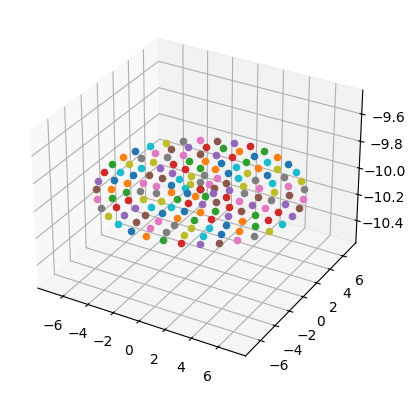

In [3]:
# grid = generate_cuboid_grid(**config['cuboid_grid'])
grid = generate_cylindrical_grid(**config['cylindrical_grid'])
print(len(grid))

# Visualize the grid...
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for point in grid:
    ax.scatter(point[0], point[1], point[2])

In [4]:
# Load in scene components
materials = create_materials(with_fluids=True)
components0 = load_components(materials)
if config['use_distorted_jar']:
    components0.pop('outer_jar_outer_surface')
    components0.update({
        'outer_jar_outer_surface_top': mi.load_dict({
            'type': 'ply',
            # Note: scene_dir and object_format are defined in setup.py
            'filename': scene_dir+'outer_jar_outer_surface_top_distorted'+object_format,
            'face_normals': False,
            'bsdf': materials['outer_jar_outer_surface_mat'],
        }),
        'outer_jar_outer_surface_bottom': mi.load_dict({
            'type': 'ply',
            'filename': scene_dir+'outer_jar_outer_surface_bottom'+object_format,
            'face_normals': False,
            'bsdf': materials['outer_jar_outer_surface_mat'],
        }),
    })
components1 = components0.copy()
components1.update({
    'outer_jar_outer_surface_top': mi.load_dict({
        'type': 'ply',
        # Note: scene_dir and object_format are defined in setup.py
        'filename': scene_dir+'outer_jar_outer_surface_top'+object_format,
        'face_normals': False,
        'bsdf': materials['outer_jar_outer_surface_mat'],
    }),
})

# # Remove all refractive surfaces from components0
# components0.pop('viewports_outer', None)
# components0.pop('viewports_inner', None)
# components0.pop('outer_jar_outer_surface', None)
# components0.pop('outer_jar_inner_surface', None)
# components0.pop('inner_jar_outer_surface', None)
# components0.pop('inner_jar_inner_surface', None)

sensor = create_sensor(sensor_number=2, sample_count=config['spp'])

2024-06-18 15:15:36 WARN main [PLYMesh] "outer_jar_outer_surface_top_distorted.ply": skipping unknown element "edge"

2024-06-18 15:15:36 WARN main [PLYMesh] "outer_jar_outer_surface_top.ply": skipping unknown element "edge"

In [5]:
locations0 = [] # bubble image pixel locations without refractive surfaces
locations1 = [] # bubble image pixel locations *with* refractive surfaces

for point in grid:
    
    # Add the bubble to the scene
    components0.update({
        'bubble': mi.load_dict({
            'type': 'sphere',
            'focused-emitter': materials['emitter'],
            'to_world': mi.ScalarTransform4f.translate(point).scale(config['bubble_scale']),
        })
    })
    components1.update({
        'bubble': mi.load_dict({
            'type': 'sphere',
            'focused-emitter': materials['emitter'],
            'to_world': mi.ScalarTransform4f.translate(point).scale(config['bubble_scale']),
        })
    })

    scene0 = load_scene(components=components0, sensor=sensor)
    render0 = render(scene0, denoise=False)[:,:,0]
    trender0 = np.where(render0>config['threshold'], render0, 0).astype(np.uint8)
    circles0 = cv2.HoughCircles(trender0, **config['hough_params'])
    if circles0 is not None:
        locations0.append(circles0.reshape(-1, 3)[0])
    else:
        locations0.append(None)

    scene1 = load_scene(components=components1, sensor=sensor)
    render1 = render(scene1, denoise=False)[:,:,0]
    trender1 = np.where(render1>config['threshold'], render1, 0).astype(np.uint8)
    circles1 = cv2.HoughCircles(trender1, **config['hough_params'])
    if circles1 is not None:
        locations1.append(circles1.reshape(-1, 3)[0])
    else:
        locations1.append(None)


In [6]:
# If the location is None in either list of locations, remove the corresponding element in the other list as well
Nones0 = [i for i in range(len(locations0)) if locations0[i] is None]
for j in range(len(Nones0)):
    del locations0[Nones0[j]]
    del locations1[Nones0[j]]
    Nones0 = [i-1 for i in Nones0]

Nones1 = [i for i in range(len(locations1)) if locations1[i] is None]
for j in range(len(Nones1)):
    del locations0[Nones1[j]]
    del locations1[Nones1[j]]
    Nones1 = [i-1 for i in Nones1]

print(len(locations0))
print(locations0)
print("This should be empty: ", [i for i in range(len(locations0)) if locations0[i] is None])
print()
print(len(locations1))
print(locations1)
print("This should be empty: ", [i for i in range(len(locations1)) if locations1[i] is None])

145
[array([645.      , 400.5     ,  15.961662], dtype=float32), array([645.      , 400.5     ,  15.961662], dtype=float32), array([645.      , 400.5     ,  15.961662], dtype=float32), array([645.      , 400.5     ,  15.961662], dtype=float32), array([625.5     , 400.5     ,  15.966167], dtype=float32), array([630.      , 414.      ,  16.222494], dtype=float32), array([642.      , 423.      ,  15.915754], dtype=float32), array([655.5     , 420.      ,  15.465858], dtype=float32), array([664.5     , 409.5     ,  15.599293], dtype=float32), array([663.      , 394.5     ,  16.205462], dtype=float32), array([652.5     , 382.5     ,  16.545387], dtype=float32), array([642.      , 379.5     ,  16.210323], dtype=float32), array([630.      , 387.      ,  16.065975], dtype=float32), array([606.     , 400.5    ,  16.24206], dtype=float32), array([612.      , 421.5     ,  16.686617], dtype=float32), array([624.      , 436.5     ,  16.293583], dtype=float32), array([640.5     , 444.      ,  15.270

[641 401 396]


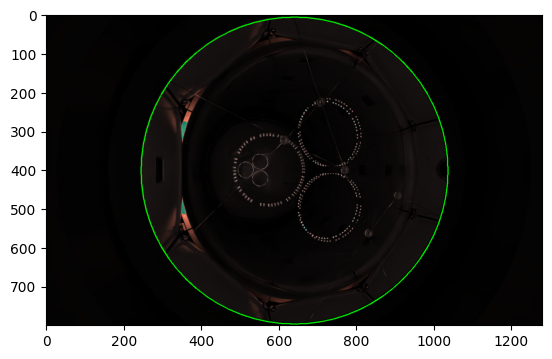

In [7]:
# Determine the portion of the renders that bounds the viewport (and potentially the jars)
components1.pop('bubble', None) # remove the bubble
sensor1 = create_sensor(sensor_number=2, sample_count=528)
scene = load_scene(components1, sensor1)
rend = np.array(256*render(scene, denoise=True), dtype=np.uint8)
rendr = rend[:,:,0]
hough_params_2 = {
    'method': cv2.HOUGH_GRADIENT_ALT,
    'dp': 1,
    'minDist': 5,
    'param1': 50,
    'param2': 0.975,
    'minRadius': 100,
    'maxRadius': 500
}
bounds = cv2.HoughCircles(rendr, **hough_params_2).reshape(-1, 3)
circles = np.uint16(np.around(bounds))
for circle in circles:
    print(circle)
    cv2.circle(rend, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
plt.imshow(rend)

In [8]:
# Get viewport circle
vp = bounds[0]
print(vp)

[641.     401.     395.5357]


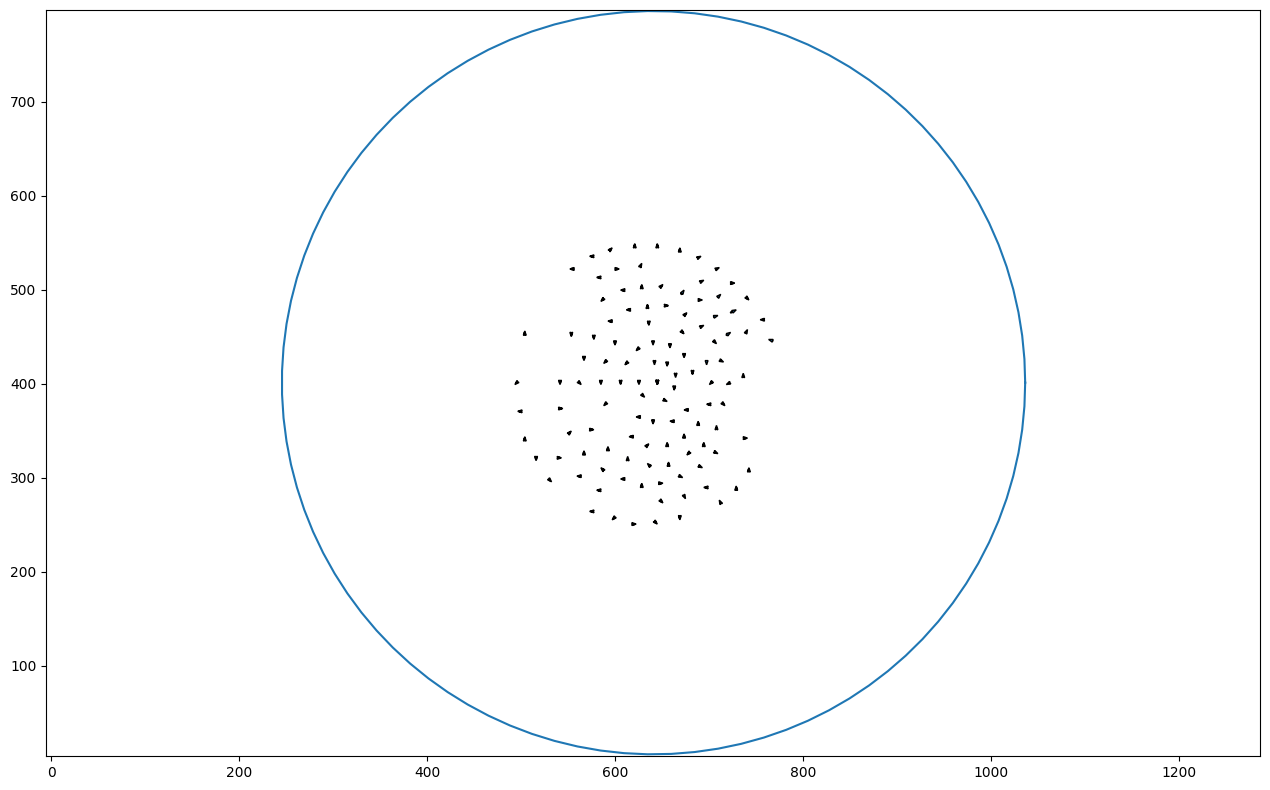

In [9]:
# Extract the point locations...
xp0 = []
yp0 = []
for loc in locations0:
    xp0.append(loc[0])
    yp0.append(loc[1])

xp1 = []
yp1 = []
for loc in locations1:
    xp1.append(loc[0])
    yp1.append(loc[1])

# Set up plot params
plt.figure(figsize=(12.8, 8))
plt.axis('equal')
plt.xlim((1, 1280))
plt.ylim((1, 800))
plt.tight_layout()

# Draw arrows between each corresponding pair of points
for i in range(len(xp0)):
    plt.arrow(xp0[i], yp0[i], xp1[i]-xp0[i], yp1[i]-yp0[i], width=1.0, length_includes_head=True)

# # Draw the points themselves
# plt.scatter(xp0, yp0, s=10.0, c='b')
# plt.scatter(xp1, yp1, s=10.0, c='r')

# Draw the bounding circle of the viewport for reference
an = np.linspace(0, 2.0 * np.pi, 100)
plt.plot(vp[0] + vp[2] * np.cos(an), vp[1] + vp[2] * np.sin(an))

In [10]:
# Compute distortion coefficients [k1, k2]

xc = np.mean(xp0)
yc = np.mean(yp0)
print("Center of grid in image: ", xc, yc)

A = np.zeros((2*len(locations0), 2))
i = 0
for posn in locations0:
    x = posn[0] - xc
    y = posn[1] - yc
    r2 = x*x + y*y
    r4 = r2*r2
    A[i, 0] = r2
    A[i, 1] = r4
    A[i+1, 0] = r2
    A[i+1, 1] = r4
    i += 2

b = np.zeros((2*len(locations0), 1))
j = 0
for i in range(0, len(locations0), 2):
    b[i]   = locations1[j][0] / locations0[j][0] - 1
    b[i+1] = locations1[j][1] / locations0[j][1] - 1
    j += 1

# Using QR decomposition
Q, R = np.linalg.qr(A)
distortion_ceoffs = np.linalg.inv(R) @ Q.T @ b
print(distortion_ceoffs)

# Using pseudo inverse
distortion_ceoffs_ = pseudo_inverse(A) @ b
print(distortion_ceoffs_)

Center of grid in image:  631.5517 402.93103
[[-2.58097641e-08]
 [ 1.39237541e-12]]
[[-2.58097641e-08]
 [ 1.39237541e-12]]


4.644089711942713


(-151.92687150098928,
 153.32697241921255,
 -167.38105631619064,
 160.99516144288407)

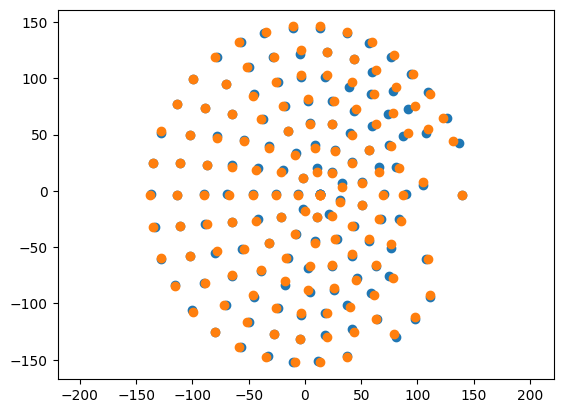

In [11]:
# Compute the re-projection mean square error using the distortion coefficients

def apply_distortion(x:float, y:float, k1:float, k2:float) -> tuple[float, float]:
    r2 = x*x + y*y
    r4 = r2*r2
    x_ = (1 + k1*r2 + k2*r4) * x
    y_ = (1 + k1*r2 + k2*r4) * y
    return x_, y_

projected = []
actual = []
for i in range(len(locations0)):
    x = locations0[i][0] - xc
    y = locations0[i][1] - yc
    x_, y_ = apply_distortion(x, y, distortion_ceoffs[0], distortion_ceoffs[1])
    projected.append([x_[0], y_[0]])

    ax = locations1[i][0] - xc
    ay = locations1[i][1] - yc
    actual.append([ax, ay])

projected = np.array(projected)
actual = np.array(actual)
error = np.sum((projected - actual)**2)/len(locations0)
# error = np.linalg.norm((projected - actual))
print(error)

# Visualize the difference between the projected and actual points...
plt.scatter(projected[:,0], projected[:,1])
plt.scatter(actual[:,0], actual[:,1])
plt.axis('equal')